In [8]:
#General use
import numpy as np
from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo

#For creating a list of .fits files to perform photometry on
import os

#For reading and creating tables
from astropy.table import Table
import astropy.io.ascii as asc

#For performing photometry
from astropy import units as u
from photutils import aperture_photometry, SkyCircularAperture, CircularAperture
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

#For generating a plot
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline


In [9]:
def Conv_error(val, err): 

    '''
    Find error in the conversion factor from arcmin^2 to Kpc^2 using a black box error method.

    Args:
        val (float): A redshift value
        err (float): Error in the redshift
        
    Returns:
        error (float): Error in the conversion factor
    '''

    error = abs(.5 * (
                (1 / cosmo.kpc_comoving_per_arcmin(val + err))**2
                 - (1 / cosmo.kpc_comoving_per_arcmin(val - err))**2
                )).value
    
    return(error)

def Comov_error(val, err): 
    
    '''
    Find error in the comoving distance using a black box error method

    Args:
        val (float): A redshift value
        err (float): Error in the redshift
        
    Returns:
        error (float): Error in the comoving distance 
    '''

    error = abs(.5 * (cosmo.comoving_distance(val + err).cgs
                 - cosmo.comoving_distance(val - err).cgs)).value 
    
    return(error)

def Flux_error(pho_val, pho_err, conv_val, conv_err):

    '''
    Find error in the calculated flux due to error in the measured photon counts per second
    and flux conversion factor.
    
    Args:
        pho_val  (float): Average photon counts per second
        pho_err  (float): Error in pho_val
        conv_val (float): A conversion factor from average photon counts to flux
        conv_err (float): Error in conv_val
        
    Returns:
        error (float): Error in the associated flux value
    '''

    error = ((pho_val * conv_err)**2 + (conv_val * pho_err)**2)**(.5)
    return(error)

def Luminosity_error(flux_val, flux_err, dist_val, dist_err): 

    '''
    Find error in the calculated Luminosity due error in the flux and comoving distance 
    
    Args:
        flux_val (float): Average photon counts per second
        flux_err (float): Error in val
        dist_val (float): Comoving distance
        dist_err (float): Error in comoving distance
        
    Returns:
        error (float): Error in the luminosity
    '''

    error = ((4 * np.pi * (dist_val**2) * flux_err)**2
             + (8 * np.pi * dist_val * flux_val * dist_err)**2)**(.5)
    
    return(error)

def Sbrightness_error(lum_val, lum_err, conv_val, conv_err):
    
    '''
    Find the error in surface brightness 
    
    Args:
        lum_val  (float): Luminosity of a supernova environment
        lum_err  (float): Error in the luminosity
        conv_val (float): Conversion factor from arcmin^2 to Kpc^2 
        conv_err (float): Error in the conversion factor
        
    Returns:
        error (float): Error in the Surface brightness
    '''
    
    error = ((conv_val * lum_err / pixel_area)**2
             + (lum_val * conv_err / pixel_area)**2)**(.5)
    
    return(error)

def zero_check(fits_file, cord, r):

    '''
    Perform photometry on a wt type .fits file and check if there are data pixels in a given
    aperture.
    
    Args:
        fits_file (str)      : The file path of a .fits file
        cord      (SkyCoord) : The (ra, dec) of a supernova in degrees
        r         (Quantity) : The radius of a photometry aperture in arcmin.

    Returns:
        in_file (bool): [supernova name(string), photometry value (float), exposure time (float)]
        'no check file'  (str) : Returned if there is no check file
    '''

    if(os.path.isfile(fits_file.replace(file_key,check_file_key))):
          
        hdulist = fits.open(fits_file.replace(file_key,check_file_key))
        aperture = SkyCircularAperture(cord, r)
        phot_table = aperture_photometry(hdulist[0], aperture)
        in_file = phot_table[0][0]!=0
        return(in_file)
    
    else:
        return('no check file')

def photometry(fits_file):
    
    '''
    Perform photometry on a .fits file using a 1kpc radius aperture. 
    
    Args:
        fits_file (str): The file path of a .fits file

    Returns:
        results               (list): [supernova name (string), photometry value (float),
                                        exposure time (float)]
                                        
        'no check file'       (str) : Returned if photometry of a supernova is zero and 
                                        there was no check file
                                        
        'failed check file'   (str) : Returned if no supernova is found in the .fits file
    '''
    
    #open the file and create an hdulist
    hdulist = fits.open(fits_file)
    sci = hdulist[0].data
    wcs = WCS(fits_file)

    for sn in cord:

        #Define the SN location in pixels
        w = wcs.all_world2pix(cord[sn].ra,cord[sn].dec, 1)
        
        #Make sure the sn is located in the image
        if 0<w[0]<3600 and 0<w[1]<3600:

            #get exposure time and create an array of the error in each pixel
            exp_time = hdulist[0].header['EXPTIME']
            error = ((hdulist[0].data*exp_time)**(1/2))/exp_time
            
            #Find arcmin of a 1kpc radius region
            r = 2*u.kpc/cosmo.kpc_comoving_per_arcmin(float(red[sn]))
            
            #Create an aperture
            aperture = SkyCircularAperture(cord[sn], r) 
            
            #Perform photometry
            phot_table = aperture_photometry(hdulist[0], aperture, error=error)
            results = [sn, phot_table, exp_time]
            
            if phot_table[0][0]!=0 or zero_check(fits_file, cord[sn], r)==True:
                return(results)
            
            elif zero_check(fits_file, cord[sn], r)=='no check file':
                return('no check file')
            
            elif zero_check(fits_file, cord[sn], r)==False:
                return('failed check file')
            
    hdulist.close()
    return(False)


In [50]:
#User set parameters

region_file = "observed_target_info.reg" #A region file with supernova coordinates and redshifts

fits_directory='./' #The directory to look for .fits files in   

output_file="output " #The output file name without an extension.

uv_type = 'NUV' #Specify FUV or NUV observations


In [51]:
#Automaticcally set parameters that are specific to NUV or FUV observations

if 'N' in uv_type.upper():
    
    file_key = "nd-int" #A string located in the file name of all the files that will be analyzed
    check_file_key = "nd-wt" #A string to replace file_key in the file path of the the check file
    flux_conv = 2.06*(10**(-16)) #A conversion factor from counts per second to flux
    plot_name = 'Supernova Region Brightness in the NUV' #The title of the output plot
        
elif 'F' in uv_type.upper():
    file_key = "fd-int" 
    check_file_key = "fd-wt" 
    flux_conv = 1.40*10**(-15) 
    plot_name = 'Supernova Region Brightness in the FUV'


flux_conv_err = 0 #Error in flux_conv
pixel_area=(1.5/60)**2 #Arcmin^2 per pixel 


In [52]:
#Create a list of .fits files to perform photometry on

file_list = []

for path, subdirs, files in os.walk(fits_directory):
    for name in files:
        if file_key in name: file_list.append(os.path.join(path, name))


In [53]:
#Create dictionaries for the coordinates (in degrees) and redshift 
#of supernova by using values from the .reg file and from Friedman data table.csv

reg = asc.read(region_file, data_start=2, delimiter = "#", header_start=2)
cord, red = {}, {}

for row in reg: 
    cord[row[1].split(",")[0].strip('text={}')] = SkyCoord(
        row[0].strip('point()').replace(',',' '), unit=(u.hourangle, u.deg))

    red[row[1].split(",")[0].strip('text={}')] = row[1].split(",")[2].strip('}').replace('z=','')

reg = asc.read('Friedman data table.csv', delimiter = ",")
for row in reg:
    red[row[0]]=row[4]
    cord[row[0]]=SkyCoord(ra=row[1]*u.degree, dec=row[2]*u.degree)


In [54]:
#Define Tables used to generate the output files

log = Table(names=['Issue', 'File Path'], dtype=[object, object])
out = Table(names=[
            'Sn Name', 'Red shift', 'Redshift error', 'ArcMin^2 per Kpc^2 at Redshift', 
            'ArcMin^2 / Kpc^2 error', 'Photometry N/s', 'Exposure Time (s)', 
            'Photometry Error N^(1/2)/s', 'Flux (erg s-1 cm-2 A-1 px-1)', 
            'Flux error (erg s-1 cm-2 A-1 px-1)', 'Luminosity (erg s-1 A-1 px-1)', 
            'Luminosity Error (erg s-1 A-1 px-1)', 'Surface Brightness (erg s-1 A-1 Kpc^-2)', 
            'Surface Brightness error (erg s-1 A-1 Kpc^-2)', 'log10 of Surface Brightness', 
            'Error in log10', 'File Path'], 
          
          dtype=(
            object, 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 
            'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64',
            'float64', 'float64', object))

#We perform photometry on each .fits file

ind = {}
n=0

for fits_file in file_list:

    p = photometry(fits_file)
    if p==False: 
        log.add_row(['No Supernova Found', fits_file])
        
    elif p=='no check file':
        log.add_row(['No Check File', fits_file])
    
    elif p=='failed check file':
        log.add_row(['Failed Check File', fits_file])
  
    else:
        n+=1
        
        #We calculate the values to be entered in the table
        
        redshift = float(red[p[0]])
        peculiar_redshift = ((1 + (300 / 299792.458)) / (1 - (300 / 299792.458)))**.5 - 1
        redshift_err = ((redshift / 1000)**2 + (peculiar_redshift)**2)**(.5) 
        
        arcmin = (1 / cosmo.kpc_comoving_per_arcmin(redshift).value)**2 #arcmin^2 per Kpc^2
        arcmin_err = Conv_error(redshift, redshift_err)
        
        photom = p[1][0][0] #The photometry value
        photom_err = p[1][0][1]
        
        flux = flux_conv * photom #convert cps to flux using the conversion factor
        flux_err = Flux_error(photom, photom_err, flux_conv, flux_conv_err)
        
        cmd = cosmo.comoving_distance(redshift).cgs.value #Comoving Distance at Redshift (cm)
        cmd_err = Comov_error(redshift,redshift_err)
        
        lum = flux * 4 * np.pi * (cmd**2) #luminosity = flux*4*pi*r^2
        lum_err = Luminosity_error(flux,flux_err,cmd,cmd_err)
        
        sbrightness = (lum / pixel_area) * arcmin 
        sbrightness_err = Sbrightness_error(lum,lum_err,arcmin,arcmin_err)
        
        log_sbrightness = np.log10(sbrightness)
        log_sbrightness_err = sbrightness_err / (sbrightness * np.log(10))
        
        if p[0] not in ind: 
            out.add_row([p[0], redshift, redshift_err, arcmin, arcmin_err, photom, p[2],
                    photom_err, flux, flux_err, lum, lum_err, sbrightness, sbrightness_err,
                    log_sbrightness, log_sbrightness_err, fits_file])
            
            ind[p[0]] = len(out)-1
            
        elif out['Surface Brightness error (erg s-1 A-1 Kpc^-2)'][ind[p[0]]]>sbrightness_err:
            out.remove_row(ind[p[0]])
            out.add_row([p[0], redshift, redshift_err, arcmin, arcmin_err, photom, p[2],
                    photom_err, flux, flux_err, lum, lum_err, sbrightness, sbrightness_err,
                    log_sbrightness, log_sbrightness_err, fits_file])
        
            ind[p[0]] = len(out)-1
        

print('Photometry finished:', n, 'supernova oberved.')

Photometry finished: 263 supernova oberved.


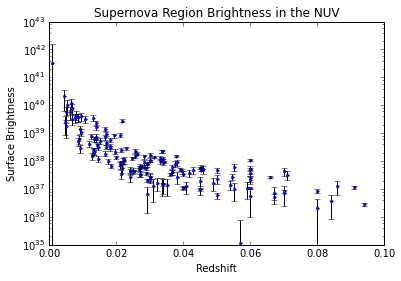

In [55]:
#We create a plot of the results and write them to a pdf file
 
ax = plt.gca()
ax.set_yscale('log')
ax.plot(out['Red shift'], out['Surface Brightness (erg s-1 A-1 Kpc^-2)'],'.')
ax.errorbar(out['Red shift'], out['Surface Brightness (erg s-1 A-1 Kpc^-2)'],
            xerr=None, yerr=out['Surface Brightness error (erg s-1 A-1 Kpc^-2)'],
            color='black', linestyle='')


plt.xlabel('Redshift')
plt.ylabel('Surface Brightness')
plt.title(plot_name)

plt.savefig(output_file + uv_type + ' plot.pdf')
plt.show()
plt.close()



In [56]:
#Write data to an output file

asc.write(out, output_file + ' ' + uv_type + '.csv', delimiter=",")
asc.write(log, output_file + ' ' + uv_type + ' log.csv', delimiter=",")
print('Script finished')


Script finished
